In [8]:
import tensorflow as tf
from tensorflow.keras.models import save_model
#from tensorflow.python.framework import ops
import tensorflow.keras.layers as L
#import tensorflow.compat.v1.keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import keras_utils
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Conv2DTranspose, Reshape
from keras.models import Model
from sklearn.datasets import fetch_lfw_people
from PIL import Image
import os
import pandas as pd
import glob
import imageio

#####################

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/faces.zip

In [ ]:
DATASET_PATH ="lfw-deepfunneled/"
ATTRIBUTES_PATH = "lfw_attributes.txt"

In [ ]:
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})

dataset = pd.DataFrame(dataset)
#too much Bush

In [ ]:
def fetch_dataset(dx=80,dy=80, dimx=128,dimy=128):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos,all_attrs

In [ ]:
data, _ = fetch_dataset()

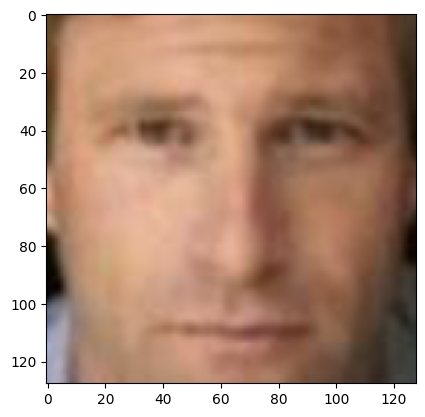

In [ ]:
plt.imshow(data[0])

In [ ]:
%rm -rf lfw-deepfunneled

##############################

In [ ]:
IMG_SHAPE = (128, 128, 3)
code_size = 200

In [ ]:
#Encoder
encoder_input = Input(shape=IMG_SHAPE)

#conv1
encoder_cnn1 = Conv2D(filters = 8, kernel_size = (2, 2),strides = (2, 2), activation='elu', padding='same')(encoder_input)
# encoder_MaxPooling1 = MaxPooling2D(pool_size = (2, 2))(encoder_cnn1)

#conv2
encoder_cnn2 = Conv2D(filters = 16, kernel_size = (2, 2),strides = (2, 2), activation='elu', padding='same')(encoder_cnn1)
# encoder_MaxPooling2 = MaxPooling2D(pool_size = (2, 2))(encoder_cnn2)

#conv3
encoder_cnn3 = Conv2D(filters = 32, kernel_size = (2, 2),strides = (2, 2), activation='elu', padding='same')(encoder_cnn2)
# encoder_MaxPooling3 = MaxPooling2D(pool_size = (2, 2))(encoder_cnn3)

#conv4
encoder_cnn4 = Conv2D(filters = 64, kernel_size = (2, 2),strides = (2, 2), activation='elu', padding='same')(encoder_cnn3)
# encoder_MaxPooling4 = MaxPooling2D(pool_size = (2, 2))(encoder_cnn4)

#conv5
encoder_cnn5 = Conv2D(filters = 128, kernel_size = (2, 2),strides = (2, 2), activation='elu', padding='same')(encoder_cnn4)
# encoder_MaxPooling5 = MaxPooling2D(pool_size = (2, 2))(encoder_cnn5)

#conv6
encoder_cnn6 = Conv2D(filters = 256, kernel_size = (2, 2),strides = (2, 2), activation='elu', padding='same')(encoder_cnn5)
# encoder_MaxPooling6 = MaxPooling2D(pool_size = (2, 2))(encoder_cnn6)

#Dense
flattend = Flatten()(encoder_cnn6)
encoder_output = tf.keras.layers.Dense(units=code_size, name="encoder_dense_1")(flattend)

In [ ]:
encoder = tf.keras.models.Model(encoder_input, encoder_output, name="encoder_model")
encoder.summary()

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         104       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        528       
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        2080      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          8256      
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 128)         32896     
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 256)       

In [ ]:
#Decoder
decoder_input = Input(shape=code_size)

#Dense
decoder_dense = tf.keras.layers.Dense(units=2*2*256, name="encoder_dense_1")(decoder_input)
decoder_reshape = Reshape((2, 2, 256))(decoder_dense)

#conv1
decoder_output1 = Conv2DTranspose(filters = 128, kernel_size = (3, 3), strides=2 , activation='elu', padding='same')(decoder_reshape)

#conv2
decoder_output2 = Conv2DTranspose(filters = 64, kernel_size = (3, 3), strides=2 , activation='elu', padding='same')(decoder_output1)

#conv3
decoder_output3 = Conv2DTranspose(filters = 32, kernel_size = (3, 3), strides=2 , activation='elu', padding='same')(decoder_output2)

#conv4
decoder_output4 = Conv2DTranspose(filters = 16, kernel_size = (3, 3), strides=2, activation='elu', padding='same')(decoder_output3)

#conv5
decoder_output5 = Conv2DTranspose(filters = 16, kernel_size = (3, 3), strides=2, activation='elu', padding='same')(decoder_output4)

#conv5
decoder_output6 = Conv2DTranspose(filters = 3, kernel_size = (3, 3), strides=2, activation='elu', padding='same')(decoder_output5)

In [ ]:
decoder = tf.keras.models.Model(decoder_input, decoder_output6, name="decoder_model")

In [ ]:
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 encoder_dense_1 (Dense)     (None, 1024)              205824    
                                                                 
 reshape (Reshape)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 128)        295040    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 64)         73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 16, 16, 32)     

In [ ]:
ae_input = tf.keras.layers.Input(shape=(128, 128, 3), name="AE_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = Model(ae_input, ae_decoder_output, name="AE")

In [ ]:
ae.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

In [ ]:
data = data.astype('float32') / 255

NameError: ignored

In [ ]:
data, _ = train_test_split(data, test_size=0.2, random_state=42, shuffle = True)

In [ ]:
data, test = train_test_split(data, test_size=0.1, random_state=42, shuffle = True)

In [ ]:
ae.fit(data, data, epochs=1000, batch_size=256, shuffle=True, validation_data=(test, test))

In [ ]:
import matplotlib.pyplot as plt
decoded_imgs = ae.predict(test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()